## Bonn Database Analysis

#### Importing Libraries

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.signal import welch, butter, filtfilt, decimate

#### Importing data from the Bonn Database

In [4]:
# Defining directories
directories = ['Z', 'O', 'N', 'F', 'S']
base_path = './bonn_database/'

# healthy volunteer data
data_Z = [] # eyes open
data_O = [] # eyes closed

# presurgical diagnosis data
data_N = [] # not seizure - within the lesion area (hipocampus)
data_F = [] # not seizure - within the other hemisphere's hipocampus
data_S = [] # from both - seizure data

original_fs = 173.61 # sampling frequency

# Reading data from each directory
for dir_name in directories:
    dir_path = os.path.join(base_path, dir_name)
    for file_name in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file_name)
        data = np.loadtxt(file_path)
        if dir_name == 'Z':
            data_Z.append(data)
        elif dir_name == 'O':
            data_O.append(data)
        elif dir_name == 'N':
            data_N.append(data)
        elif dir_name == 'F':
            data_F.append(data)
        elif dir_name == 'S':
            data_S.append(data)

# Convert lists to numpy ndarrays
data_Z = np.array(data_Z)
data_O = np.array(data_O)
data_N = np.array(data_N)
data_F = np.array(data_F)
data_S = np.array(data_S)

print(f"Data Z shape: {data_Z.shape}")
print(f"Data O shape: {data_O.shape}")
print(f"Data N shape: {data_N.shape}")
print(f"Data F shape: {data_F.shape}")
print(f"Data S shape: {data_S.shape}")

Data Z shape: (100, 4097)
Data O shape: (100, 4097)
Data N shape: (100, 4097)
Data F shape: (100, 4097)
Data S shape: (100, 4097)


#### Filtering and downsampling the data

In [5]:
# defines the filter to be used
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [6]:
# filtering step
lowcut = 0.5
highcut = 40
down_factor = 2 # downsampling factor
filt_Z = decimate(bandpass_filter(data_Z, lowcut, highcut, original_fs), down_factor)
filt_O = decimate(bandpass_filter(data_O, lowcut, highcut, original_fs), down_factor)
filt_N = decimate(bandpass_filter(data_N, lowcut, highcut, original_fs), down_factor)
filt_F = decimate(bandpass_filter(data_F, lowcut, highcut, original_fs), down_factor)
filt_S = decimate(bandpass_filter(data_S, lowcut, highcut, original_fs), down_factor)
fs = original_fs / down_factor

### Visualizing the EEG's and their spectrum

This is important so we can see the 2 features we are working with:
- The EEG's (raw, time-based data)
- The spectrum of the EEG's (frequency domain data)

In [21]:
# calculates the power spectral density for each data

frequencies, PSD_Z = welch(filt_Z, fs=fs, nperseg=256)
_, PSD_O = welch(filt_O, fs=fs, nperseg=256)
_, PSD_N = welch(filt_N, fs=fs, nperseg=256)
_, PSD_F = welch(filt_F, fs=fs, nperseg=256)
_, PSD_S = welch(filt_S, fs=fs, nperseg=256)

print(f"PSD Z shape: {PSD_Z.shape}")
# print(frequencies) # 0-43 Hz, near Nyquist frequency


PSD Z shape: (100, 129)


#### Plotting Samples

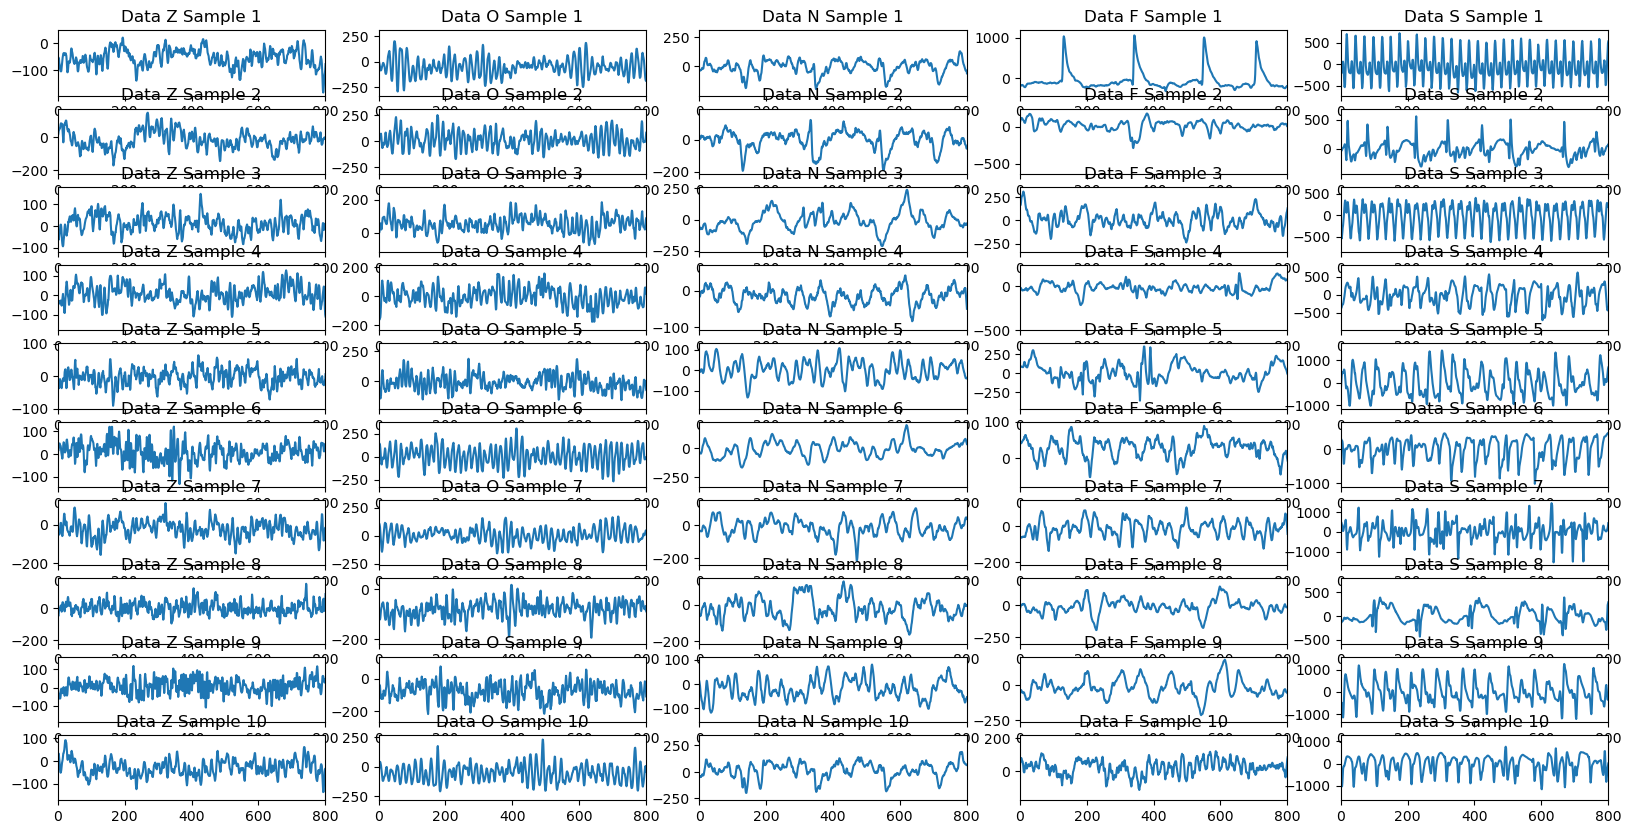

In [45]:
import matplotlib.pyplot as plt

samples_to_plot = 10

# also plot the data in the time domain
fig, axs = plt.subplots(samples_to_plot, 5, figsize=(20, 10))

# Plot time domain data for each dataset
for i in range(samples_to_plot):
    axs[i, 0].plot(data_Z[i])
    axs[i, 0].set_xlim(0, 800)
    axs[i, 0].set_title(f'Data Z Sample {i+1}')
    
    axs[i, 1].plot(data_O[i])
    axs[i, 1].set_xlim(0, 800)
    axs[i, 1].set_title(f'Data O Sample {i+1}')
    
    axs[i, 2].plot(data_N[i])
    axs[i, 2].set_xlim(0, 800)
    axs[i, 2].set_title(f'Data N Sample {i+1}')
    
    axs[i, 3].plot(data_F[i])
    axs[i, 3].set_xlim(0, 800)
    axs[i, 3].set_title(f'Data F Sample {i+1}')
    
    axs[i, 4].plot(data_S[i])
    axs[i, 4].set_xlim(0, 800)
    axs[i, 4].set_title(f'Data S Sample {i+1}')

#### Plotting FFT's

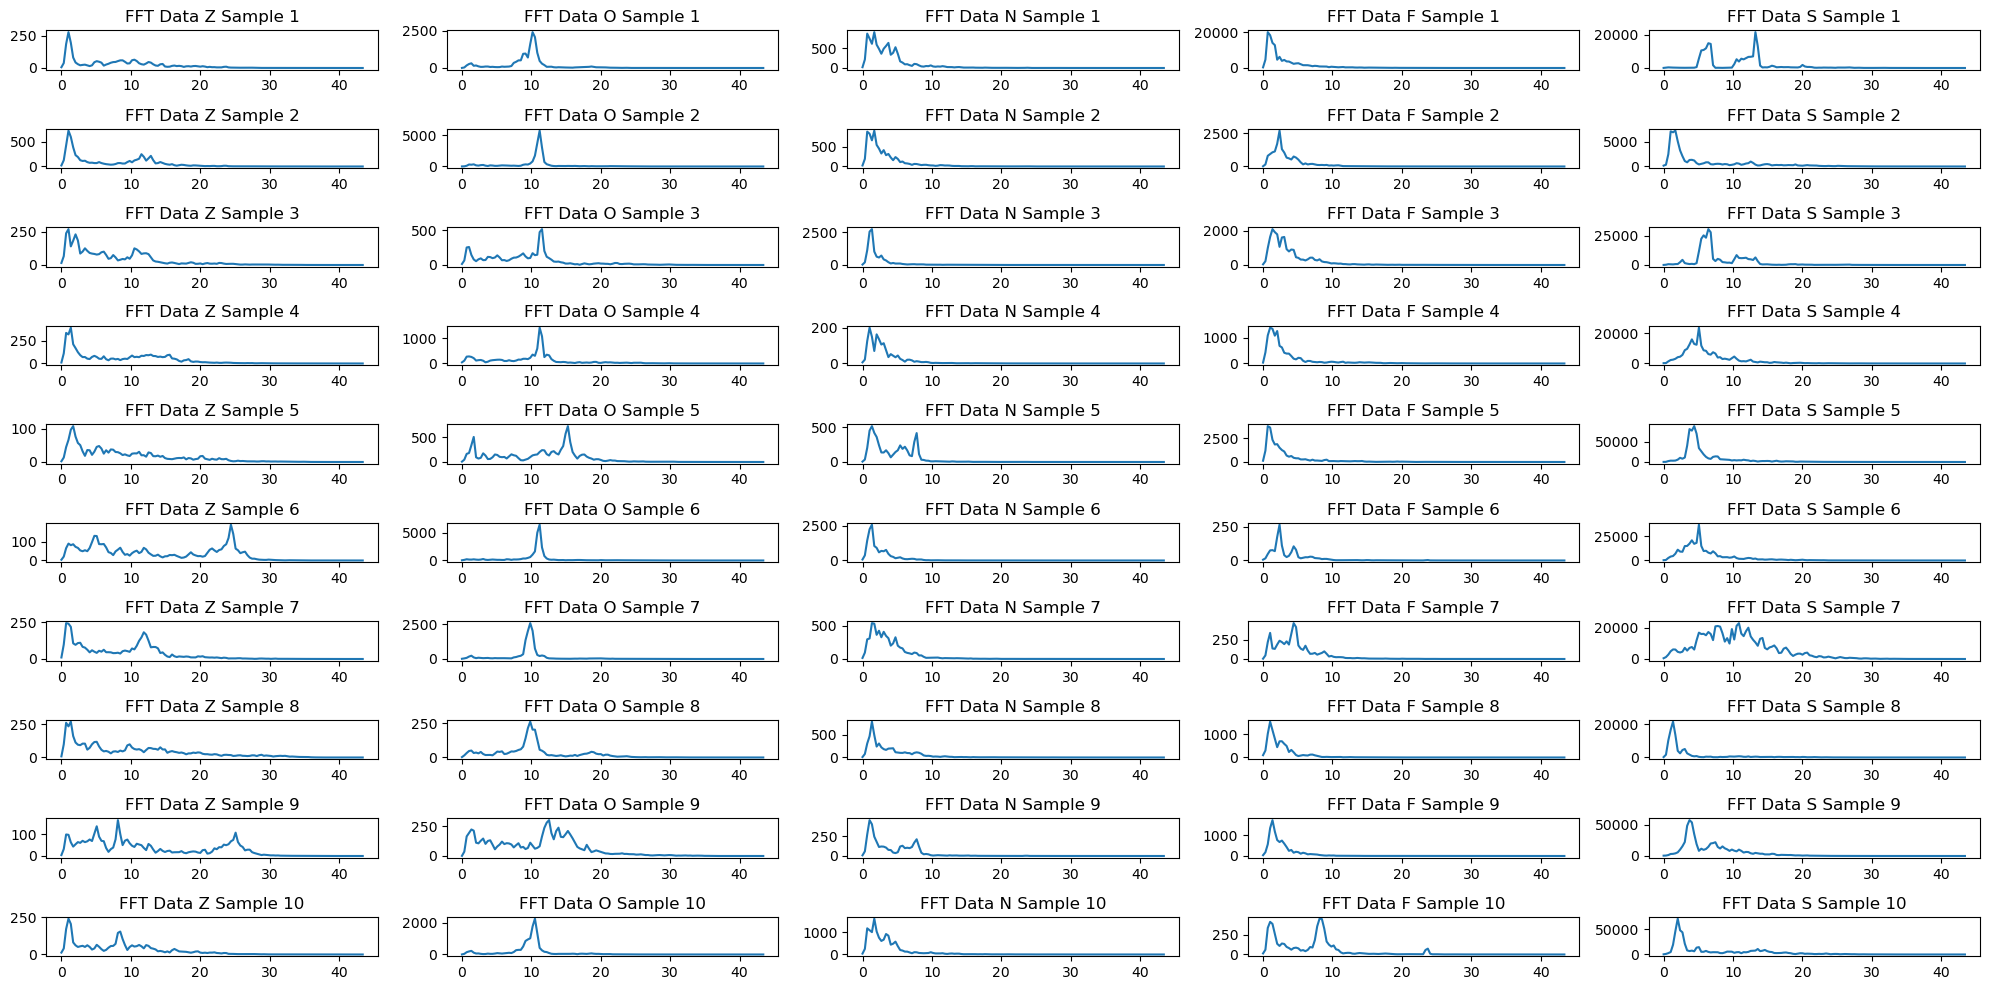

In [46]:
fig, axs = plt.subplots(samples_to_plot, 5, figsize=(20, 10))

# Plot FFTs for each dataset
for i in range(samples_to_plot):
    axs[i, 0].plot(frequencies, PSD_Z[i])
    axs[i, 0].set_title(f'FFT Data Z Sample {i+1}')
    
    axs[i, 1].plot(frequencies, PSD_O[i])
    axs[i, 1].set_title(f'FFT Data O Sample {i+1}')
    
    axs[i, 2].plot(frequencies, PSD_N[i])
    axs[i, 2].set_title(f'FFT Data N Sample {i+1}')
    
    axs[i, 3].plot(frequencies, PSD_F[i])
    axs[i, 3].set_title(f'FFT Data F Sample {i+1}')
    
    axs[i, 4].plot(frequencies, PSD_S[i])
    axs[i, 4].set_title(f'FFT Data S Sample {i+1}')

# Adjust layout
plt.tight_layout()
plt.show()

### Doing some feature engineering
The main features i aim to extract are:

- the power of the EEG on each of the main literature frequency bands (delta, theta, alpha, beta, gamma);
- and the relative power of each of these bands;

Maybe i will also try to extract some other features like the Hjorth parameters, the fractal dimension and the entropy...

In [33]:
def band_power(frequencies, psd, band):
    """ Calcula a potência dentro de uma banda de frequência específica """
    band_idx = np.logical_and(frequencies >= band[0], frequencies <= band[1])  
    return np.trapz(psd[band_idx], frequencies[band_idx])

bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 40)
}

band_powers_Z_df = pd.DataFrame({band: [band_power(frequencies, psd, bands[band]) for psd in PSD_Z] for band in bands})
band_powers_O_df = pd.DataFrame({band: [band_power(frequencies, psd, bands[band]) for psd in PSD_O] for band in bands})
band_powers_N_df = pd.DataFrame({band: [band_power(frequencies, psd, bands[band]) for psd in PSD_N] for band in bands})
band_powers_F_df = pd.DataFrame({band: [band_power(frequencies, psd, bands[band]) for psd in PSD_F] for band in bands})
band_powers_S_df = pd.DataFrame({band: [band_power(frequencies, psd, bands[band]) for psd in PSD_S] for band in bands})


In [44]:
norm_band_powers_Z_df = band_powers_Z_df.div(band_powers_Z_df.sum(axis=1), axis=0)

print(band_powers_Z_df.describe())
print(norm_band_powers_Z_df.describe())


             Delta       Theta       Alpha         Beta       Gamma
count   100.000000  100.000000  100.000000   100.000000  100.000000
mean    477.335812  242.517494  262.002306   347.542505    9.189281
std     229.503224   86.857923  123.293802   171.210566    9.096854
min     115.329175   80.637208   60.078867   100.108046    1.504294
25%     304.639429  179.747805  164.918584   200.787318    4.471605
50%     448.192428  236.061946  255.255567   324.304942    6.665141
75%     575.762258  291.232576  347.423737   453.506628    9.857152
max    1165.080967  483.659745  599.671255  1003.649014   53.115423
            Delta       Theta       Alpha        Beta       Gamma
count  100.000000  100.000000  100.000000  100.000000  100.000000
mean     0.353924    0.188376    0.191823    0.259135    0.006741
std      0.094848    0.052045    0.051609    0.082459    0.005791
min      0.153779    0.097158    0.085493    0.108838    0.001323
25%      0.280870    0.160780    0.156149    0.201163    0

### Now trying to do some classifiers, with the 4 different feature sets